# **Battle of the Neighborhood Parks**

## *Eli Cizewski-Robinson*

### **Introduction**

My final project investigates which Boroughs and Neighborhoods have the most and the most highly rated parks. Parks improve the quality of life in the surrounding area, they provide a place of refuge from a bustling city, a bit of nature in the middle of one of the largest metropolises on earth, a place to play and relax. I want to investigate where in New York City has the most parks, where has the best parks and if those are the same neighborhood.  

### **Data**

In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, parks, and park ratings and tips are required. 

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset 

New York City data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm 

All data related to locations and quality of Parks will be obtained via the FourSquare API utilized via the Request library in Python. 

### **Methodology**

• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe. 

• FourSquare be used to locate all venues and then filtered by Parks. Ratings, tips, and likes by users will be counted and added to the dataframe. 

• Data will be sorted based on rankings 

• Finally, the data be will be visually assessed using graphing from various Python libraries. 

### **Problem Statement** 

1. What is the neighboorhood in New York City has the most parks? 
2. What Borough has the most parks per square kilometer?
3. Is there an obvious best neighborhood/borough for parks?

In [11]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from bs4 import BeautifulSoup
import lxml
import os
import seaborn as sns
print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [22]:
CLIENT_ID = 'O3LFLVSW0VHD5MH240ONYVFPOBH0DQ4FCFYAVUDMRYVU0UD0' # your Foursquare ID
CLIENT_SECRET = 'TJAS34CAOXAO22UVQSAS5LKLWZXTZAYGRLFNBZRA3QTVBSPK' # your Foursquare Secret
VERSION = '20200608'

In [23]:
def geo_location(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    radius=400
    LIMIT=100
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='
    resp=requests.get(url).json()
    features=resp['features']
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [14]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


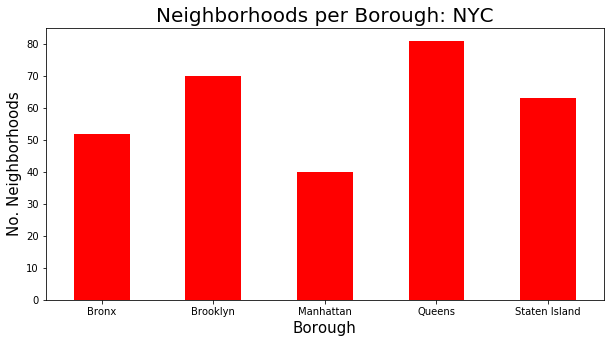

In [15]:
clr = "red"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [96]:
ny_data.groupby('Borough')['Neighborhood'].count()

Borough
Bronx            52
Brooklyn         70
Manhattan        40
Queens           81
Staten Island    63
Name: Neighborhood, dtype: int64

# Borough Size
###### From https://en.wikipedia.org/wiki/Boroughs_of_New_York_City
| Borough      | Square Km | Neighborhood Count |Neighborhood per Sq Km|
| ----------- | ----------- | ----------- | ----------- |
| Bronx      | 109.04      |52|0.47|
| Brooklyn   | 183.42       |70|0.38|
| Manhattan   | 59.13        |40|0.68|
| Queens   | 281.09        |81|0.29|
| Staten Island   | 151.18        |63|0.42|
|**Total**|**783.83**|**306**|**0.39**|


Manhattan is the smallest Borough, Queens is the biggest. Neighborhood count is very roughly correlated with Borough size. It is also worth noting that Central park is 3.41 Sq Km, so its 17.34% of the total area of Manhattan.

In [43]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
parks_nyc=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    parks=venues[venues['Category']=='Park']   
    print('(',count,'/',len(ny_data),')','Parks in '+Neighborhood+', '+Borough+':'+str(len(italian_resturants)))
    print(row)
    for park_detail in parks.values.tolist():
        id, name , category=park_detail
        parks_nyc = parks_nyc.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1



( 1 / 306 ) Parks in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Parks in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Parks in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Parks in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Parks in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Parks in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Parks in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Parks in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Parks in Norwood, Bronx:0
['Bronx', 'Norwood', 40.87722415599446, -73.8793907395681]
( 10 / 306 ) Parks in Williamsbridge, Bronx:0
['Bronx', 'Williamsbrid

In [44]:
parks_nyc.to_csv('parks_nyc_tocsv1.csv')

In [59]:
parks_nyc = pd.read_csv('parks_nyc_tocsv1.csv')
parks_nyc.drop(columns=['Unnamed: 0'],inplace=True)
parks_nyc.tail()

,Borough,Neighborhood,ID,Name
118,Brooklyn,Dumbo,4f6b61d8e4b0e15b873dad2f,Picnic Grove
119,Brooklyn,Highland Park,4cddebf7aba88cfa802b3ed7,Highland Park
120,Bronx,Kingsbridge Heights,4dbf5056cda12687c8321adb,Washington's Walk
121,Manhattan,Hudson Yards,55d12634498ee6d387a520a5,Bella Abzug Park
122,Queens,Queensbridge,4be4f03b2468c9281590ff42,Queensbridge Park


In [60]:
parks_nyc.shape

(123, 4)

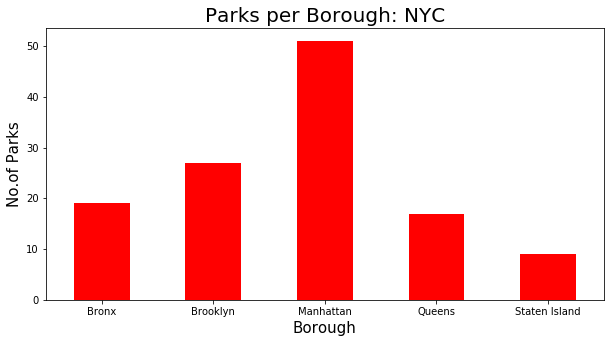

In [61]:
    parks_nyc.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Parks per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Parks', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [110]:
parks_nyc.groupby('Borough')['ID'].count()

Borough
Bronx            19
Brooklyn         27
Manhattan        51
Queens           17
Staten Island     9
Name: ID, dtype: int64

| Borough      | Square Km | Neighborhood Count |Neighborhood per Sq Km|Parks|Parks per Sq Km|
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| Bronx      | 109.04      |52|0.47|19|0.17|
| Brooklyn   | 183.42       |70|0.38|27|0.38|
| Manhattan   | 59.13        |40|0.68|51|0.67|
| Queens   | 281.09        |81|0.29|17|0.29|
| Staten Island   | 151.18        |63|0.42|9|0.42|
|**Total**|**783.83**|**306**|**0.39**|**123**|**0.16**|

Despite being the smallest Borough Manhattan has the most parks. It also has the highest Park per Sq Km.

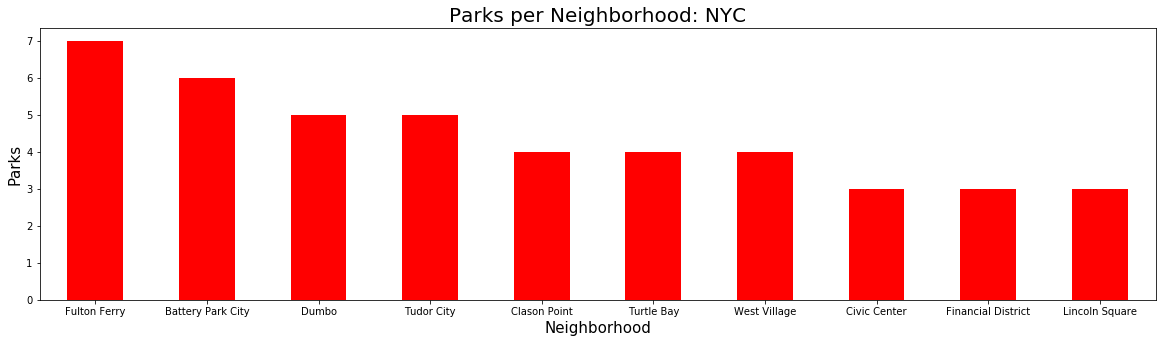

In [122]:
NOofNeigh = 10
parks_nyc.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(20,5), color=clr)
plt.title('Parks per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Parks', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

The Neighborhood with the most parks is in Brooklyn. Overall seven of the top ten are in Manhattan, two are in Brooklyn, one is in the Bronx and none are in Queens and Staten Island. 

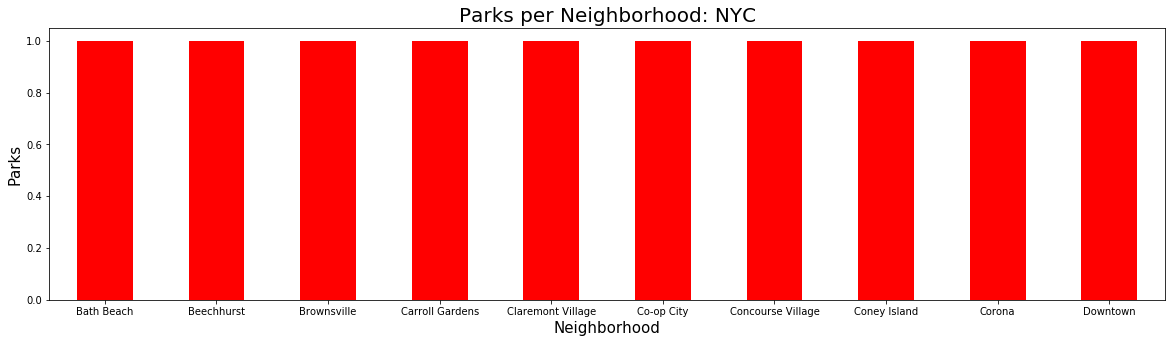

In [124]:
 NOofNeigh = 10
parks_nyc.groupby('Neighborhood')['ID'].count().nsmallest(NOofNeigh).plot.bar(figsize=(20,5), color=clr)
plt.title('Parks per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Parks', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

No Neighborhood has zero parks. So the range is one park to seven parks, nothing too extreme.

In [63]:
parks_nyc[parks_nyc['Neighborhood']=='Fulton Ferry']

,Borough,Neighborhood,ID,Name
106,Brooklyn,Fulton Ferry,430d0a00f964a5203e271fe3,Brooklyn Bridge Park
107,Brooklyn,Fulton Ferry,4b81ea40f964a520e0c330e3,Brooklyn Bridge Park - Pier 1
108,Brooklyn,Fulton Ferry,4b955a1af964a520f29d34e3,Empire Fulton Ferry Park
109,Brooklyn,Fulton Ferry,4f6b61d8e4b0e15b873dad2f,Picnic Grove
110,Brooklyn,Fulton Ferry,4ebac60a0cd6904066e4108f,Brookyn Bridge Park Greenway
111,Brooklyn,Fulton Ferry,4c7b0c5297028cfa5c37e0fe,Squibb Park
112,Brooklyn,Fulton Ferry,540e9f18498e42bb5d05a4dc,Harbor View Lawn


In [125]:
parks_nyc[parks_nyc['Neighborhood']=='Battery Park City']

,Borough,Neighborhood,ID,Name
54,Manhattan,Battery Park City,4c1164576e5dc9b69506b02d,Battery Park City Esplanade
55,Manhattan,Battery Park City,4caf6091cbab236a6fa49773,Hudson River Trail
56,Manhattan,Battery Park City,576c2212498e72c8c38f1ddd,Liberty Park
57,Manhattan,Battery Park City,4ead6837b8f765aba14d35fd,Pier 46 @ Hudson River Park
58,Manhattan,Battery Park City,4bcc9b6668f976b0a7ec6283,Pumphouse Park
59,Manhattan,Battery Park City,4bdfde5b0d69b713542c66d3,Rector Park


Manhattan has the most parks per square kilometer, the largest park in the city and seven of the top ten neighborhoods with the most parks. If you care about greenspace Manhattan seems like a no brainer. I do wish I could find a dataset that includes the square kilometers of the parks, but I'm guessing that Central Park being 17% of Manhattan means it would have the most greenspace per kilometer as well. 